In [1]:
import pandas as pd
import sys
import datetime
import matplotlib.pylab as plt
import numpy as np
from math import log, floor, ceil
from typing import Dict

In [2]:
START_DATE = datetime.date(2020,2,24)

In [3]:
def create_filename(day: datetime.date) -> str:
    day_str = day.strftime("%Y%m%d")
    return ('../dati-province/dpc-covid19-ita-province-' + day_str + '.csv')

In [4]:
def handle_Toscana_20200326_error(cases: Dict[str, int]) -> Dict[str, int]:
    cases['20200327'] = cases['20200326'] + floor((cases['20200328'] - cases['20200326'])/2)
    cases['20200328'] = cases['20200327'] + ceil((cases['20200328'] - cases['20200326'])/2)
    return cases

In [5]:
def calculate_and_create_chart_for_province(start_date: datetime.date, province: str):
    day = start_date
    cases: Dict[str,int] = {}
    while day<=datetime.date.today():
        day_str: str = day.strftime("%Y%m%d")
        filename: str = create_filename(day)
        df: pd.DataFrame = pd.read_csv(filename, encoding = "ISO-8859-1")
        cases[day_str] = int(df[df["denominazione_provincia"]==province]["totale_casi"])
        day: datetime.date = day + datetime.timedelta(days = 1)
    
    if df[df["denominazione_provincia"]==province]["denominazione_regione"].any()=='Toscana':
        cases = handle_Toscana_20200326_error(cases)
    
    cases_df: pd.DataFrame = pd.DataFrame.from_dict(cases, orient='index')
    cases_df = cases_df.reset_index()
    cases_df = cases_df.rename(columns={"index": "Day", 0: "Cases"})
    
    cases_df_today = cases_df[cases_df["Day"]==datetime.date.today().strftime("%Y%m%d")]["Cases"].sum()
    print("Total cases per 1000 inhabitants up to today:", round(calculate_cases_to_inhabitants_ratio(cases_df_today, province),4))
    calculate_stats(cases_df)

    x = cases_df.index
    y = cases_df["Cases"]
    plt.scatter(x, y)

    z = np.polyfit(x, y, 3)
    p = np.poly1d(z)
    plt.plot(x,p(x),"r--")
    plt.grid()

    plt.show()
    return

In [6]:
def calculate_and_create_chart_for_region(start_date: datetime.date, region: str):
    day: datetime.date = start_date
    cases: Dict[str, int] = {}
    while day<=datetime.date.today():
        day_str: str = day.strftime("%Y%m%d")
        filename: str = '../dati-province/dpc-covid19-ita-province-' + day_str + '.csv'
        df: pd.DataFrame = pd.read_csv(filename, encoding = "ISO-8859-1")
        cases[day_str] = int(df[(df["denominazione_regione"]==region)&(df["denominazione_provincia"]!='In fase di definizione/aggiornamento')]["totale_casi"].sum())
        day: datetime.date = day + datetime.timedelta(days = 1)
        
    if region == 'Toscana':
        cases = handle_Toscana_20200326_error(cases)

    cases_df = pd.DataFrame.from_dict(cases, orient='index')
    cases_df = cases_df.reset_index()
    cases_df = cases_df.rename(columns={"index": "Day", 0: "Cases"})
    
    calculate_stats(cases_df)

    x = cases_df.index
    y = cases_df["Cases"]
    plt.scatter(x, y)

    z = np.polyfit(x, y, 3)
    p = np.poly1d(z)
    plt.plot(x,p(x),"r--")
    plt.grid()
    plt.yscale("log")
    plt.show()
    return

In [7]:
def calculate_and_create_chart_for_Italy(start_date: datetime.date):
    day: datetime.date = start_date
    cases: Dict[str, int] = {}
    while day<=datetime.date.today():
        day_str: str = day.strftime("%Y%m%d")
        filename: str = '../dati-province/dpc-covid19-ita-province-' + day_str + '.csv'
        df: pd.DataFrame = pd.read_csv(filename, encoding = "ISO-8859-1")
        cases[day_str] = int(df[df["denominazione_provincia"]!='In fase di definizione/aggiornamento']["totale_casi"].sum())
        day: datetime.date = day + datetime.timedelta(days = 1)

    cases_df: pd.DataFrame = pd.DataFrame.from_dict(cases, orient='index')
    cases_df = cases_df.reset_index()
    cases_df = cases_df.rename(columns={"index": "Day", 0: "Cases"})
    
    calculate_stats(cases_df)

    x = cases_df.index
    y = cases_df["Cases"]
    plt.scatter(x, y)

    z = np.polyfit(x, y, 3)
    p = np.poly1d(z)
    plt.plot(x,p(x),"r--")
    plt.grid()

    plt.show()
    return

In [8]:
def calculate_stats(cases_df):
    cases_df_today = cases_df[cases_df["Day"]==datetime.date.today().strftime("%Y%m%d")]["Cases"].sum()
    cases_df_yesterday = cases_df[cases_df["Day"]==(datetime.date.today()- datetime.timedelta(days = 1)).strftime("%Y%m%d")]["Cases"].sum()
    cases_df_five_days_ago = cases_df[cases_df["Day"]==(datetime.date.today()- datetime.timedelta(days = 5)).strftime("%Y%m%d")]["Cases"].sum()
    cases_df_six_days_ago = cases_df[cases_df["Day"]==(datetime.date.today()- datetime.timedelta(days = 6)).strftime("%Y%m%d")]["Cases"].sum()
    print("Total cases up to today:", cases_df_today)
    print("New cases registered today:", cases_df_today-cases_df_yesterday)
    if int(cases_df_yesterday) != 0:
        print("New cases registered today in %:", round((cases_df_today-cases_df_yesterday)/cases_df_yesterday*100,2))

    print("Doubling time in the last five days:", round(calculate_doubling_time_in_the_last_five_days(cases_df_today, cases_df_five_days_ago), 1))
    print("Doubling time yesterday:", round(calculate_doubling_time_in_the_last_five_days(cases_df_yesterday, cases_df_six_days_ago), 1))
    print("Trend of new cases (in %) in the last 5 days:", round((cases_df_today-cases_df_five_days_ago)/cases_df_five_days_ago*100,2))
    
    return

In [9]:
def calculate_doubling_time_in_the_last_five_days(cases_df_today, cases_df_five_days_ago):
    if cases_df_five_days_ago ==0:
        return np.nan
    log_result = log(cases_df_today/cases_df_five_days_ago)
    if log_result != 0:
        return (5*log(2))/(log_result)
    else:
        return np.nan
    

In [10]:
def calculate_cases_to_inhabitants_ratio(cases: int, province: str) -> float:
    df_province: pd.DataFrame = pd.read_csv("../general/province.csv")
    inhabitants = df_province[df_province["Provincia"]==province]["Residenti"].str.replace('.', '', regex=True).sum()
    return int(cases)/int(inhabitants)*1000

# Casi di COVID-19 in Italia - COVID-19 cases in Italy

Total cases up to today: 94681
New cases registered today: 5294
New cases registered today in %: 5.92
Doubling time in the last five days: 10.0
Doubling time yesterday: 9.5
Trend of new cases (in %) in the last 5 days: 41.22


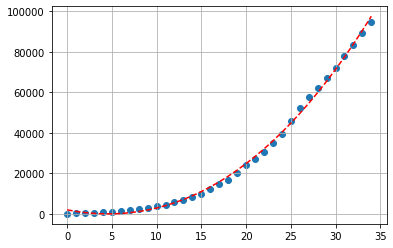

In [11]:
calculate_and_create_chart_for_Italy(START_DATE)

# Casi di COVID-19 in Abruzzo - COVID-19 cases in Abruzzo

Total cases up to today: 1293
New cases registered today: 160
New cases registered today in %: 14.12
Doubling time in the last five days: 5.5
Doubling time yesterday: 6.5
Trend of new cases (in %) in the last 5 days: 87.66


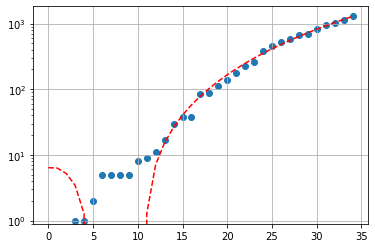

In [12]:
calculate_and_create_chart_for_region(START_DATE, 'Abruzzo')

## Chieti

Total cases per 1000 inhabitants up to today: 0.6835
Total cases up to today: 266
New cases registered today: 37
New cases registered today in %: 16.16
Doubling time in the last five days: 5.0
Doubling time yesterday: 6.0
Trend of new cases (in %) in the last 5 days: 100.0


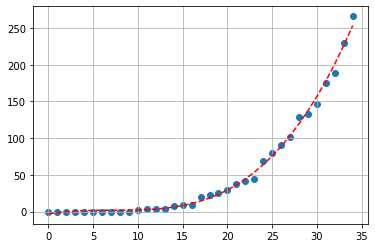

In [13]:
calculate_and_create_chart_for_province(START_DATE, 'Chieti')

## L'Aquila

Total cases per 1000 inhabitants up to today: 0.3345
Total cases up to today: 101
New cases registered today: 13
New cases registered today in %: 14.77
Doubling time in the last five days: 4.5
Doubling time yesterday: 4.4
Trend of new cases (in %) in the last 5 days: 114.89


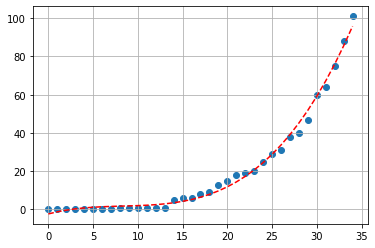

In [14]:
calculate_and_create_chart_for_province(START_DATE, "L'Aquila")

## Pescara

Total cases per 1000 inhabitants up to today: 1.7927
Total cases up to today: 576
New cases registered today: 64
New cases registered today in %: 12.5
Doubling time in the last five days: 7.8
Doubling time yesterday: 10.7
Trend of new cases (in %) in the last 5 days: 56.1


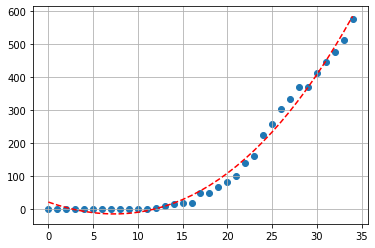

In [15]:
calculate_and_create_chart_for_province(START_DATE, 'Pescara')

## Teramo

Total cases per 1000 inhabitants up to today: 1.1295
Total cases up to today: 350
New cases registered today: 46
New cases registered today in %: 15.13
Doubling time in the last five days: 3.8
Doubling time yesterday: 3.9
Trend of new cases (in %) in the last 5 days: 150.0


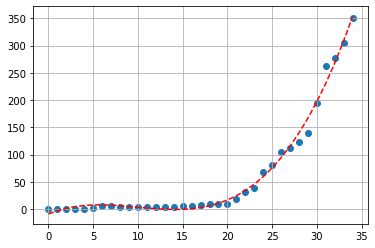

In [16]:
calculate_and_create_chart_for_province(START_DATE, 'Teramo')

# Casi di COVID-19 in Basilicata - COVID-19 cases in Basilicata

Total cases up to today: 202
New cases registered today: 20
New cases registered today in %: 10.99
Doubling time in the last five days: 4.4
Doubling time yesterday: 4.9
Trend of new cases (in %) in the last 5 days: 119.57


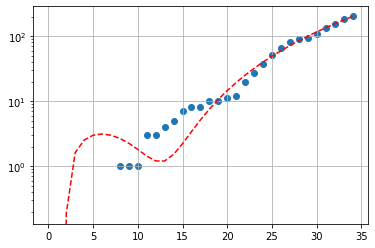

In [17]:
calculate_and_create_chart_for_region(START_DATE, 'Basilicata')

## Matera

Total cases per 1000 inhabitants up to today: 0.4207
Total cases up to today: 84
New cases registered today: 8
New cases registered today in %: 10.53
Doubling time in the last five days: 2.9
Doubling time yesterday: 2.4
Trend of new cases (in %) in the last 5 days: 236.0


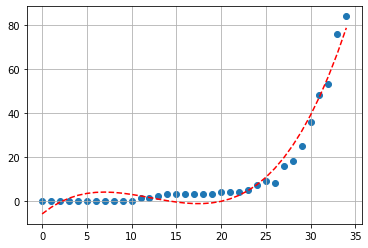

In [18]:
calculate_and_create_chart_for_province(START_DATE, 'Matera')

## Potenza

Total cases per 1000 inhabitants up to today: 0.3183
Total cases up to today: 118
New cases registered today: 12
New cases registered today in %: 11.32
Doubling time in the last five days: 6.1
Doubling time yesterday: 9.0
Trend of new cases (in %) in the last 5 days: 76.12


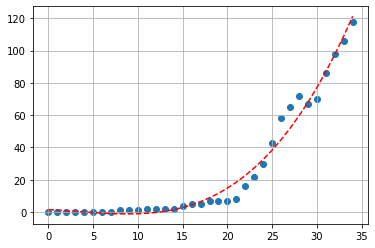

In [19]:
calculate_and_create_chart_for_province(START_DATE, 'Potenza')

# Casi di COVID-19 nella Provincia Autonoma di Bolzano - COVID-19 cases in Autonomous Province of Bolzano

Total cases up to today: 1214
New cases registered today: 105
New cases registered today in %: 9.47
Doubling time in the last five days: 7.9
Doubling time yesterday: 8.1
Trend of new cases (in %) in the last 5 days: 55.44


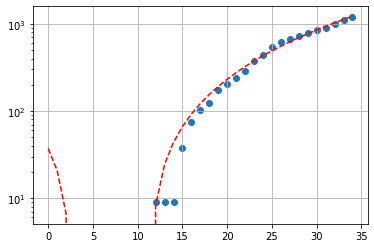

In [20]:
calculate_and_create_chart_for_region(START_DATE, 'P.A. Bolzano')

# Casi di COVID-19 in Calabria - COVID-19 cases in Calabria

Total cases up to today: 612
New cases registered today: 59
New cases registered today in %: 10.67
Doubling time in the last five days: 5.3
Doubling time yesterday: 5.4
Trend of new cases (in %) in the last 5 days: 93.06


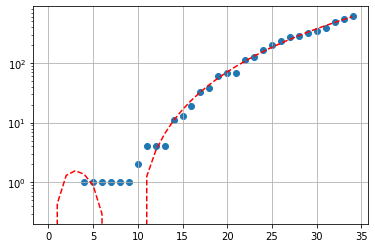

In [21]:
calculate_and_create_chart_for_region(START_DATE, 'Calabria')

## Catanzaro

Total cases per 1000 inhabitants up to today: 0.3395
Total cases up to today: 123
New cases registered today: 5
New cases registered today in %: 4.24
Doubling time in the last five days: 3.8
Doubling time yesterday: 3.7
Trend of new cases (in %) in the last 5 days: 151.02


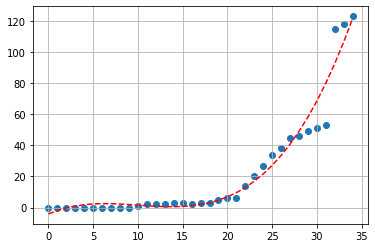

In [22]:
calculate_and_create_chart_for_province(START_DATE, 'Catanzaro')

## Cosenza

Total cases per 1000 inhabitants up to today: 0.2403
Total cases up to today: 171
New cases registered today: 17
New cases registered today in %: 11.04
Doubling time in the last five days: 4.9
Doubling time yesterday: 4.2
Trend of new cases (in %) in the last 5 days: 103.57


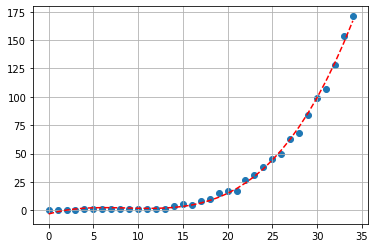

In [23]:
calculate_and_create_chart_for_province(START_DATE, 'Cosenza')

## Crotone

Total cases per 1000 inhabitants up to today: 0.5126
Total cases up to today: 90
New cases registered today: 3
New cases registered today in %: 3.45
Doubling time in the last five days: 11.2
Doubling time yesterday: 10.2
Trend of new cases (in %) in the last 5 days: 36.36


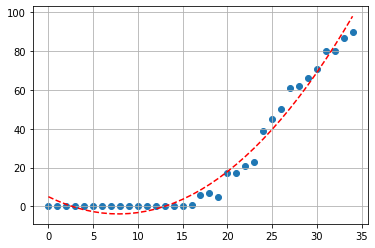

In [24]:
calculate_and_create_chart_for_province(START_DATE, 'Crotone')

## Reggio di Calabria

Total cases per 1000 inhabitants up to today: 0.3412
Total cases up to today: 189
New cases registered today: 34
New cases registered today in %: 21.94
Doubling time in the last five days: 5.2
Doubling time yesterday: 6.9
Trend of new cases (in %) in the last 5 days: 94.85


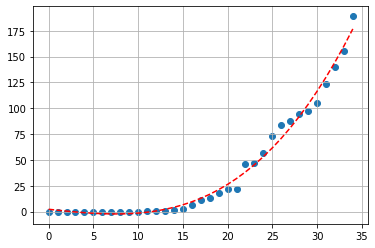

In [25]:
calculate_and_create_chart_for_province(START_DATE, 'Reggio di Calabria')

## Vibo Valentia

Total cases per 1000 inhabitants up to today: 0.2413
Total cases up to today: 39
New cases registered today: 0
New cases registered today in %: 0.0
Doubling time in the last five days: 5.6
Doubling time yesterday: 5.2
Trend of new cases (in %) in the last 5 days: 85.71


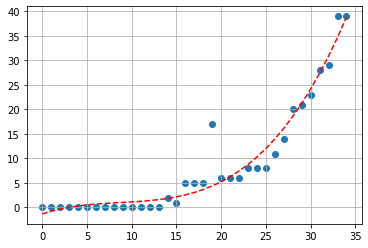

In [26]:
calculate_and_create_chart_for_province(START_DATE, 'Vibo Valentia')

# Casi di COVID-19 in Campania - COVID-19 cases in Campania

Total cases up to today: 1647
New cases registered today: 113
New cases registered today in %: 7.37
Doubling time in the last five days: 8.4
Doubling time yesterday: 8.2
Trend of new cases (in %) in the last 5 days: 50.96


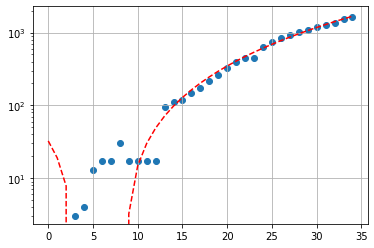

In [27]:
calculate_and_create_chart_for_region(START_DATE, 'Campania')

## Avellino

Total cases per 1000 inhabitants up to today: 0.4911
Total cases up to today: 208
New cases registered today: 15
New cases registered today in %: 7.77
Doubling time in the last five days: 11.8
Doubling time yesterday: 12.1
Trend of new cases (in %) in the last 5 days: 34.19


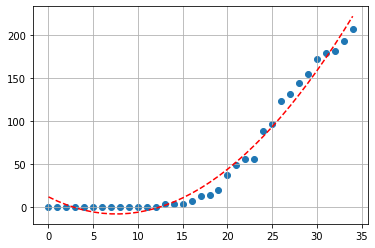

In [28]:
calculate_and_create_chart_for_province(START_DATE, 'Avellino')

## Benevento

Total cases per 1000 inhabitants up to today: 0.0751
Total cases up to today: 21
New cases registered today: 0
New cases registered today in %: 0.0
Doubling time in the last five days: 8.5
Doubling time yesterday: 7.2
Trend of new cases (in %) in the last 5 days: 50.0


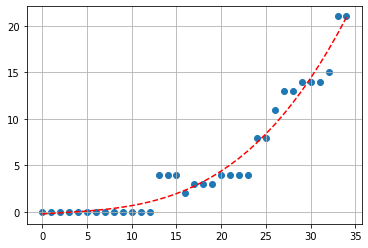

In [29]:
calculate_and_create_chart_for_province(START_DATE, 'Benevento')

## Caserta

Total cases per 1000 inhabitants up to today: 0.2132
Total cases up to today: 197
New cases registered today: 11
New cases registered today in %: 5.91
Doubling time in the last five days: 13.4
Doubling time yesterday: 8.5
Trend of new cases (in %) in the last 5 days: 29.61


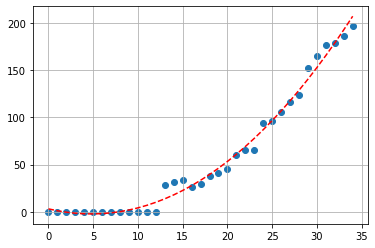

In [30]:
calculate_and_create_chart_for_province(START_DATE, 'Caserta')

## Napoli

Total cases per 1000 inhabitants up to today: 0.289
Total cases up to today: 898
New cases registered today: 71
New cases registered today in %: 8.59
Doubling time in the last five days: 8.2
Doubling time yesterday: 8.2
Trend of new cases (in %) in the last 5 days: 52.72


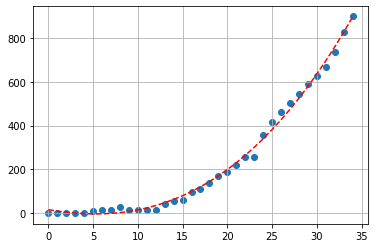

In [31]:
calculate_and_create_chart_for_province(START_DATE, 'Napoli')

## Salerno

Total cases per 1000 inhabitants up to today: 0.2924
Total cases up to today: 323
New cases registered today: 16
New cases registered today in %: 5.21
Doubling time in the last five days: 6.0
Doubling time yesterday: 6.4
Trend of new cases (in %) in the last 5 days: 77.47


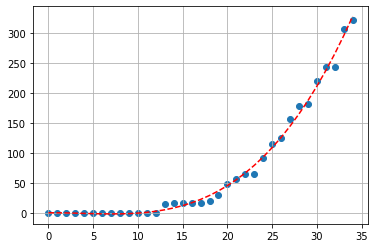

In [32]:
calculate_and_create_chart_for_province(START_DATE, 'Salerno')

# Casi di COVID-19 in Emilia Romagna - COVID-19 cases in Emilia Romagna

Total cases up to today: 13119
New cases registered today: 736
New cases registered today in %: 5.94
Doubling time in the last five days: 9.9
Doubling time yesterday: 9.3
Trend of new cases (in %) in the last 5 days: 41.77


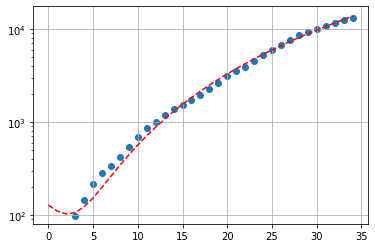

In [33]:
calculate_and_create_chart_for_region(START_DATE, 'Emilia Romagna')

## Bologna

Total cases per 1000 inhabitants up to today: 1.7271
Total cases up to today: 1743
New cases registered today: 157
New cases registered today in %: 9.9
Doubling time in the last five days: 5.9
Doubling time yesterday: 5.4
Trend of new cases (in %) in the last 5 days: 80.06


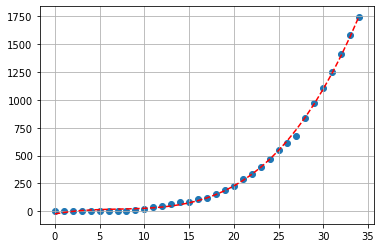

In [34]:
calculate_and_create_chart_for_province(START_DATE, 'Bologna')

## Ferrara

Total cases per 1000 inhabitants up to today: 0.8612
Total cases up to today: 300
New cases registered today: 19
New cases registered today in %: 6.76
Doubling time in the last five days: 7.6
Doubling time yesterday: 7.1
Trend of new cases (in %) in the last 5 days: 57.89


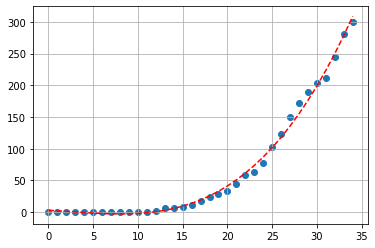

In [35]:
calculate_and_create_chart_for_province(START_DATE, 'Ferrara')

## Modena

Total cases per 1000 inhabitants up to today: 2.9877
Total cases up to today: 2094
New cases registered today: 172
New cases registered today in %: 8.95
Doubling time in the last five days: 7.9
Doubling time yesterday: 6.8
Trend of new cases (in %) in the last 5 days: 54.65


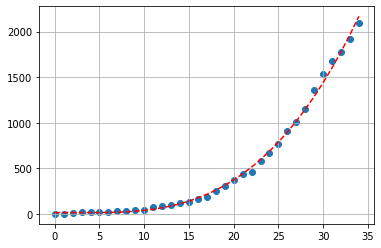

In [36]:
calculate_and_create_chart_for_province(START_DATE, 'Modena')

## Parma

Total cases per 1000 inhabitants up to today: 4.0299
Total cases up to today: 1809
New cases registered today: 57
New cases registered today in %: 3.25
Doubling time in the last five days: 15.0
Doubling time yesterday: 13.8
Trend of new cases (in %) in the last 5 days: 26.06


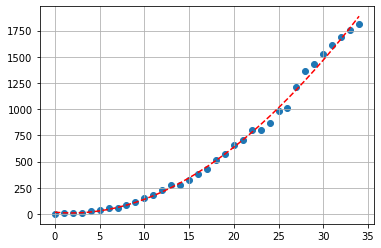

In [37]:
calculate_and_create_chart_for_province(START_DATE, 'Parma')

## Piacenza

Total cases per 1000 inhabitants up to today: 8.631
Total cases up to today: 2475
New cases registered today: 85
New cases registered today in %: 3.56
Doubling time in the last five days: 15.6
Doubling time yesterday: 14.6
Trend of new cases (in %) in the last 5 days: 24.94


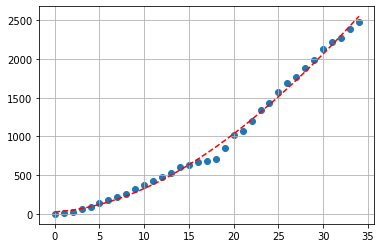

In [38]:
calculate_and_create_chart_for_province(START_DATE, 'Piacenza')

## Ravenna

Total cases per 1000 inhabitants up to today: 1.4128
Total cases up to today: 553
New cases registered today: 32
New cases registered today in %: 6.14
Doubling time in the last five days: 8.5
Doubling time yesterday: 8.2
Trend of new cases (in %) in the last 5 days: 50.27


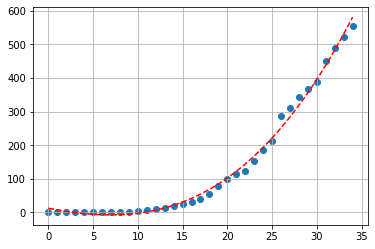

In [39]:
calculate_and_create_chart_for_province(START_DATE, 'Ravenna')

## Reggio nell'Emilia

Total cases per 1000 inhabitants up to today: 4.0302
Total cases up to today: 2146
New cases registered today: 150
New cases registered today in %: 7.52
Doubling time in the last five days: 8.6
Doubling time yesterday: 9.2
Trend of new cases (in %) in the last 5 days: 49.34


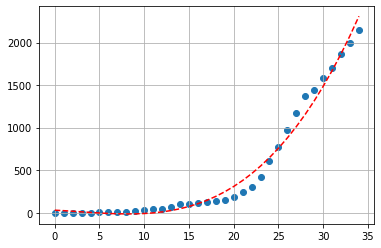

In [40]:
calculate_and_create_chart_for_province(START_DATE, "Reggio nell'Emilia")

## Rimini

Total cases per 1000 inhabitants up to today: 4.0293
Total cases up to today: 1357
New cases registered today: 34
New cases registered today in %: 2.57
Doubling time in the last five days: 15.4
Doubling time yesterday: 14.1
Trend of new cases (in %) in the last 5 days: 25.18


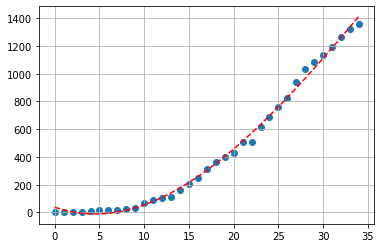

In [41]:
calculate_and_create_chart_for_province(START_DATE, 'Rimini')

# Casi di COVID-19 in Friuli Venezia Giulia - COVID-19 cases in Friuli Venezia Giulia

Total cases up to today: 1471
New cases registered today: 42
New cases registered today in %: 2.94
Doubling time in the last five days: 8.8
Doubling time yesterday: 8.1
Trend of new cases (in %) in the last 5 days: 48.29


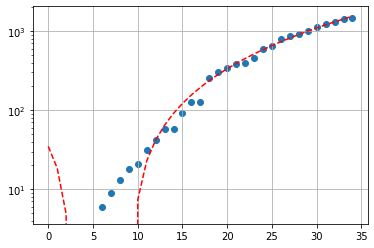

In [42]:
calculate_and_create_chart_for_region(START_DATE, 'Friuli Venezia Giulia')

## Gorizia

Total cases per 1000 inhabitants up to today: 0.6515
Total cases up to today: 91
New cases registered today: 6
New cases registered today in %: 7.06
Doubling time in the last five days: 7.4
Doubling time yesterday: 8.0
Trend of new cases (in %) in the last 5 days: 59.65


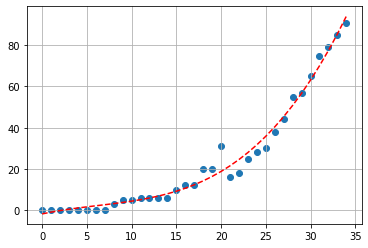

In [43]:
calculate_and_create_chart_for_province(START_DATE, 'Gorizia')

## Pordenone

Total cases per 1000 inhabitants up to today: 1.1793
Total cases up to today: 368
New cases registered today: 6
New cases registered today in %: 1.66
Doubling time in the last five days: 5.7
Doubling time yesterday: 4.6
Trend of new cases (in %) in the last 5 days: 83.08


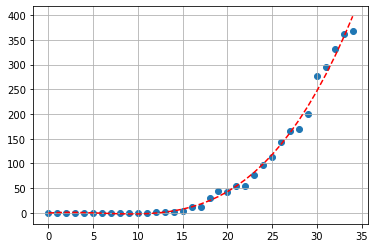

In [44]:
calculate_and_create_chart_for_province(START_DATE, 'Pordenone')

## Trieste

Total cases per 1000 inhabitants up to today: 2.0283
Total cases up to today: 476
New cases registered today: 24
New cases registered today in %: 5.31
Doubling time in the last five days: 9.4
Doubling time yesterday: 10.0
Trend of new cases (in %) in the last 5 days: 44.68


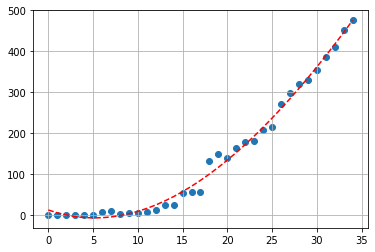

In [45]:
calculate_and_create_chart_for_province(START_DATE, 'Trieste')

## Udine

Total cases per 1000 inhabitants up to today: 1.0085
Total cases up to today: 536
New cases registered today: 6
New cases registered today in %: 1.13
Doubling time in the last five days: 12.4
Doubling time yesterday: 10.8
Trend of new cases (in %) in the last 5 days: 32.35


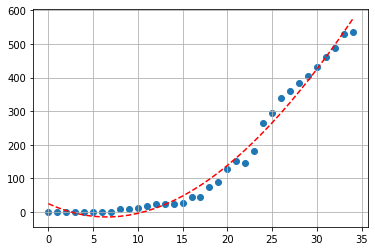

In [46]:
calculate_and_create_chart_for_province(START_DATE, 'Udine')

# Casi di COVID-19 nel Lazio - COVID-19 cases in Lazio

Total cases up to today: 2691
New cases registered today: 199
New cases registered today in %: 7.99
Doubling time in the last five days: 7.7
Doubling time yesterday: 7.2
Trend of new cases (in %) in the last 5 days: 56.45


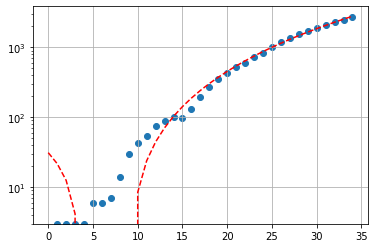

In [47]:
calculate_and_create_chart_for_region(START_DATE, 'Lazio')

## Frosinone

Total cases per 1000 inhabitants up to today: 0.5111
Total cases up to today: 252
New cases registered today: 20
New cases registered today in %: 8.62
Doubling time in the last five days: 3.6
Doubling time yesterday: 3.3
Trend of new cases (in %) in the last 5 days: 159.79


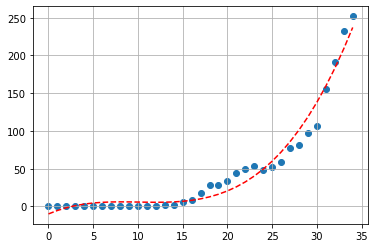

In [48]:
calculate_and_create_chart_for_province(START_DATE, 'Frosinone')

## Latina

Total cases per 1000 inhabitants up to today: 0.4157
Total cases up to today: 239
New cases registered today: 24
New cases registered today in %: 11.16
Doubling time in the last five days: 12.7
Doubling time yesterday: 11.5
Trend of new cases (in %) in the last 5 days: 31.32


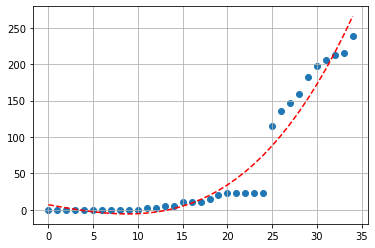

In [49]:
calculate_and_create_chart_for_province(START_DATE, 'Latina')

## Rieti

Total cases per 1000 inhabitants up to today: 0.4828
Total cases up to today: 76
New cases registered today: 14
New cases registered today in %: 22.58
Doubling time in the last five days: 4.2
Doubling time yesterday: 5.0
Trend of new cases (in %) in the last 5 days: 130.3


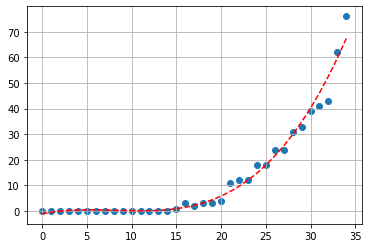

In [50]:
calculate_and_create_chart_for_province(START_DATE, 'Rieti')

## Roma

Total cases per 1000 inhabitants up to today: 0.4467
Total cases up to today: 1945
New cases registered today: 106
New cases registered today in %: 5.76
Doubling time in the last five days: 8.4
Doubling time yesterday: 7.7
Trend of new cases (in %) in the last 5 days: 51.13


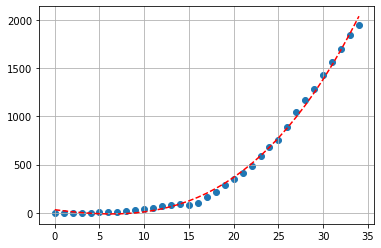

In [51]:
calculate_and_create_chart_for_province(START_DATE, 'Roma')

## Viterbo

Total cases per 1000 inhabitants up to today: 0.5611
Total cases up to today: 179
New cases registered today: 35
New cases registered today in %: 24.31
Doubling time in the last five days: 8.9
Doubling time yesterday: 7.9
Trend of new cases (in %) in the last 5 days: 47.93


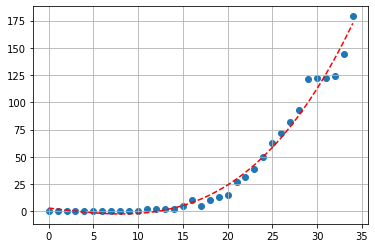

In [52]:
calculate_and_create_chart_for_province(START_DATE, 'Viterbo')

# Casi di COVID-19 in Liguria - COVID-19 cases in Liguria

Total cases up to today: 1732
New cases registered today: 164
New cases registered today in %: 10.46
Doubling time in the last five days: 9.2
Doubling time yesterday: 11.0
Trend of new cases (in %) in the last 5 days: 45.55


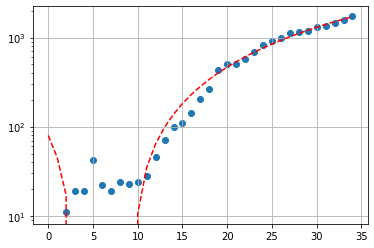

In [53]:
calculate_and_create_chart_for_region(START_DATE, 'Liguria')

## Genova

Total cases per 1000 inhabitants up to today: 1.207
Total cases up to today: 1026
New cases registered today: 147
New cases registered today in %: 16.72
Doubling time in the last five days: 8.9
Doubling time yesterday: 14.2
Trend of new cases (in %) in the last 5 days: 47.41


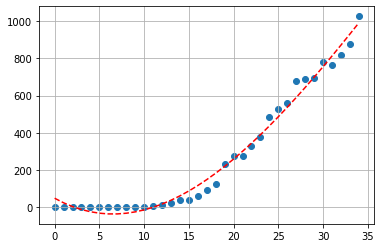

In [54]:
calculate_and_create_chart_for_province(START_DATE, 'Genova')

## Imperia

Total cases per 1000 inhabitants up to today: 1.0877
Total cases up to today: 234
New cases registered today: -2
New cases registered today in %: -0.85
Doubling time in the last five days: 15.1
Doubling time yesterday: 8.9
Trend of new cases (in %) in the last 5 days: 25.81


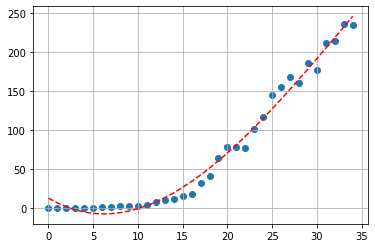

In [55]:
calculate_and_create_chart_for_province(START_DATE, 'Imperia')

## La Spezia

Total cases per 1000 inhabitants up to today: 1.0557
Total cases up to today: 233
New cases registered today: -1
New cases registered today in %: -0.43
Doubling time in the last five days: 4.3
Doubling time yesterday: 4.6
Trend of new cases (in %) in the last 5 days: 124.04


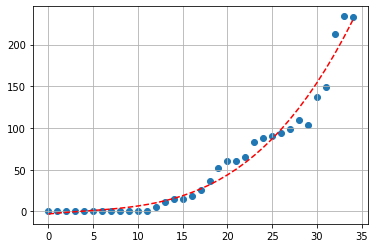

In [56]:
calculate_and_create_chart_for_province(START_DATE, 'La Spezia')

## Savona

Total cases per 1000 inhabitants up to today: 0.8554
Total cases up to today: 239
New cases registered today: 20
New cases registered today in %: 9.13
Doubling time in the last five days: 21.9
Doubling time yesterday: 20.5
Trend of new cases (in %) in the last 5 days: 17.16


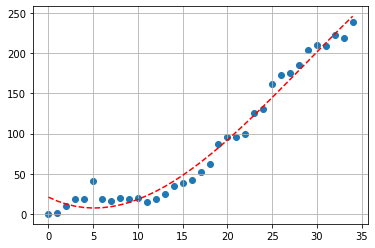

In [57]:
calculate_and_create_chart_for_province(START_DATE, 'Savona')

# Casi di COVID-19 in Lombardia - COVID-19 cases in Lombardy

Total cases up to today: 40106
New cases registered today: 1840
New cases registered today in %: 4.81
Doubling time in the last five days: 12.0
Doubling time yesterday: 11.3
Trend of new cases (in %) in the last 5 days: 33.48


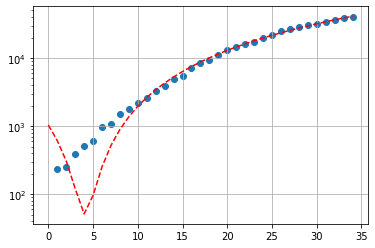

In [58]:
calculate_and_create_chart_for_region(START_DATE, 'Lombardia')

## Bergamo

Total cases per 1000 inhabitants up to today: 7.6824
Total cases up to today: 8527
New cases registered today: 178
New cases registered today in %: 2.13
Doubling time in the last five days: 14.6
Doubling time yesterday: 13.6
Trend of new cases (in %) in the last 5 days: 26.74


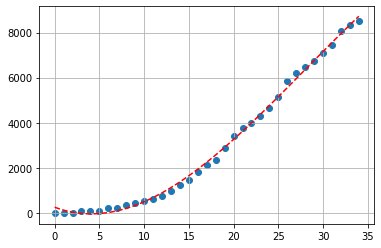

In [59]:
calculate_and_create_chart_for_province(START_DATE, 'Bergamo')

## Brescia

Total cases per 1000 inhabitants up to today: 6.3478
Total cases up to today: 8013
New cases registered today: 335
New cases registered today in %: 4.36
Doubling time in the last five days: 14.4
Doubling time yesterday: 13.2
Trend of new cases (in %) in the last 5 days: 27.23


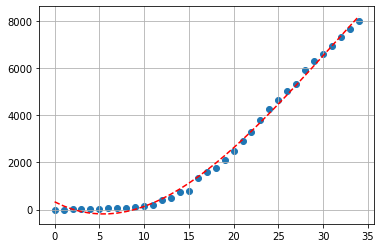

In [60]:
calculate_and_create_chart_for_province(START_DATE, 'Brescia')

## Como

Total cases per 1000 inhabitants up to today: 1.6895
Total cases up to today: 1014
New cases registered today: 111
New cases registered today in %: 12.29
Doubling time in the last five days: 7.4
Doubling time yesterday: 7.9
Trend of new cases (in %) in the last 5 days: 59.69


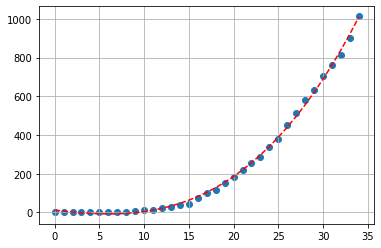

In [61]:
calculate_and_create_chart_for_province(START_DATE, 'Como')

## Cremona

Total cases per 1000 inhabitants up to today: 10.4678
Total cases up to today: 3762
New cases registered today: 157
New cases registered today in %: 4.36
Doubling time in the last five days: 16.8
Doubling time yesterday: 16.6
Trend of new cases (in %) in the last 5 days: 22.9


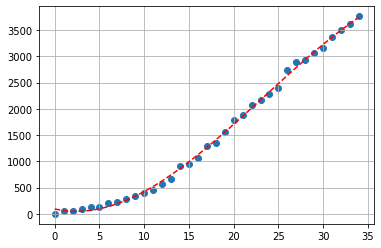

In [62]:
calculate_and_create_chart_for_province(START_DATE, 'Cremona')

## Lecco

Total cases per 1000 inhabitants up to today: 4.0709
Total cases up to today: 1381
New cases registered today: 65
New cases registered today in %: 4.94
Doubling time in the last five days: 11.3
Doubling time yesterday: 10.1
Trend of new cases (in %) in the last 5 days: 36.06


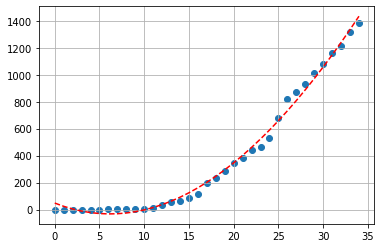

In [63]:
calculate_and_create_chart_for_province(START_DATE, 'Lecco')

## Lodi

Total cases per 1000 inhabitants up to today: 8.9693
Total cases up to today: 2057
New cases registered today: 28
New cases registered today in %: 1.38
Doubling time in the last five days: 34.4
Doubling time yesterday: 31.4
Trend of new cases (in %) in the last 5 days: 10.59


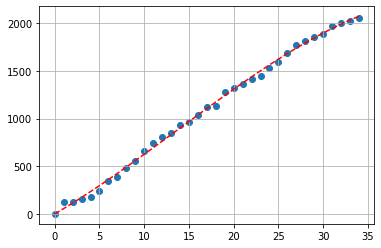

In [64]:
calculate_and_create_chart_for_province(START_DATE, 'Lodi')

## Mantova

Total cases per 1000 inhabitants up to today: 3.7566
Total cases up to today: 1550
New cases registered today: 66
New cases registered today in %: 4.45
Doubling time in the last five days: 9.9
Doubling time yesterday: 8.5
Trend of new cases (in %) in the last 5 days: 41.81


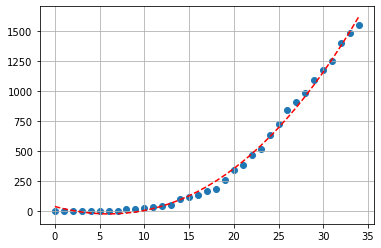

In [65]:
calculate_and_create_chart_for_province(START_DATE, 'Mantova')

## Milano

Total cases per 1000 inhabitants up to today: 2.5881
Total cases up to today: 8329
New cases registered today: 546
New cases registered today in %: 7.02
Doubling time in the last five days: 9.1
Doubling time yesterday: 9.1
Trend of new cases (in %) in the last 5 days: 46.1


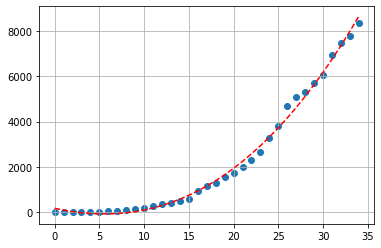

In [66]:
calculate_and_create_chart_for_province(START_DATE, 'Milano')

## Monza e della Brianza

Total cases per 1000 inhabitants up to today: 2.6069
Total cases up to today: 2265
New cases registered today: 179
New cases registered today in %: 8.58
Doubling time in the last five days: 7.8
Doubling time yesterday: 5.7
Trend of new cases (in %) in the last 5 days: 55.78


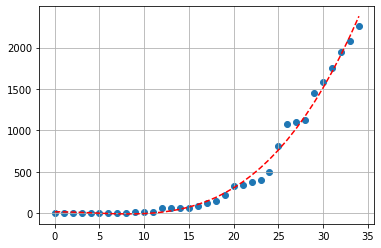

In [67]:
calculate_and_create_chart_for_province(START_DATE, 'Monza e della Brianza')

## Pavia

Total cases per 1000 inhabitants up to today: 3.6071
Total cases up to today: 1974
New cases registered today: 97
New cases registered today in %: 5.17
Doubling time in the last five days: 12.6
Doubling time yesterday: 13.2
Trend of new cases (in %) in the last 5 days: 31.69


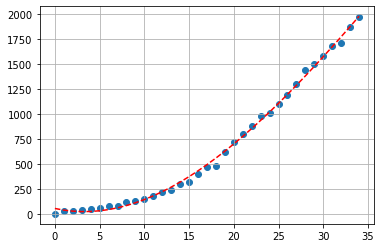

In [68]:
calculate_and_create_chart_for_province(START_DATE, 'Pavia')

## Sondrio

Total cases per 1000 inhabitants up to today: 2.3259
Total cases up to today: 422
New cases registered today: 34
New cases registered today in %: 8.76
Doubling time in the last five days: 6.8
Doubling time yesterday: 5.6
Trend of new cases (in %) in the last 5 days: 66.8


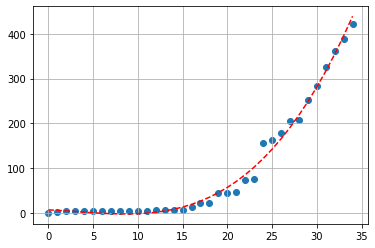

In [69]:
calculate_and_create_chart_for_province(START_DATE, 'Sondrio')

## Varese

Total cases per 1000 inhabitants up to today: 0.9123
Total cases up to today: 812
New cases registered today: 44
New cases registered today in %: 5.73
Doubling time in the last five days: 5.9
Doubling time yesterday: 5.8
Trend of new cases (in %) in the last 5 days: 80.44


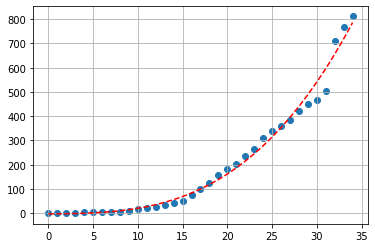

In [70]:
calculate_and_create_chart_for_province(START_DATE, 'Varese')

# Casi di COVID-19 nelle Marche - COVID-19 cases in Marche

Total cases up to today: 3497
New cases registered today: 185
New cases registered today in %: 5.59
Doubling time in the last five days: 13.3
Doubling time yesterday: 12.9
Trend of new cases (in %) in the last 5 days: 29.86


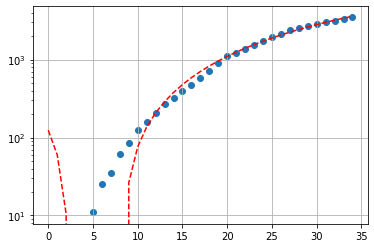

In [71]:
calculate_and_create_chart_for_region(START_DATE, 'Marche')

## Ancona

Total cases per 1000 inhabitants up to today: 2.1492
Total cases up to today: 1019
New cases registered today: 75
New cases registered today in %: 7.94
Doubling time in the last five days: 11.4
Doubling time yesterday: 11.7
Trend of new cases (in %) in the last 5 days: 35.69


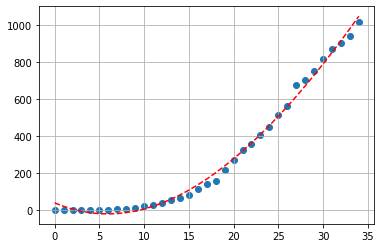

In [72]:
calculate_and_create_chart_for_province(START_DATE, 'Ancona')

## Ascoli Piceno

Total cases per 1000 inhabitants up to today: 0.8546
Total cases up to today: 179
New cases registered today: 16
New cases registered today in %: 9.82
Doubling time in the last five days: 3.4
Doubling time yesterday: 3.5
Trend of new cases (in %) in the last 5 days: 179.69


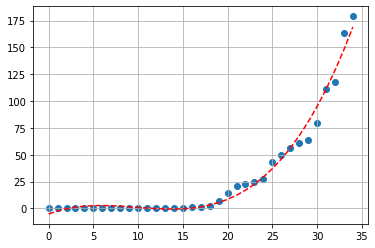

In [73]:
calculate_and_create_chart_for_province(START_DATE, 'Ascoli Piceno')

## Fermo

Total cases per 1000 inhabitants up to today: 1.4069
Total cases up to today: 246
New cases registered today: 5
New cases registered today in %: 2.07
Doubling time in the last five days: 6.1
Doubling time yesterday: 5.8
Trend of new cases (in %) in the last 5 days: 76.98


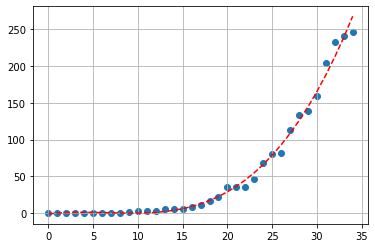

In [74]:
calculate_and_create_chart_for_province(START_DATE, 'Fermo')

## Macerata

Total cases per 1000 inhabitants up to today: 1.4925
Total cases up to today: 476
New cases registered today: 19
New cases registered today in %: 4.16
Doubling time in the last five days: 13.5
Doubling time yesterday: 10.3
Trend of new cases (in %) in the last 5 days: 29.35


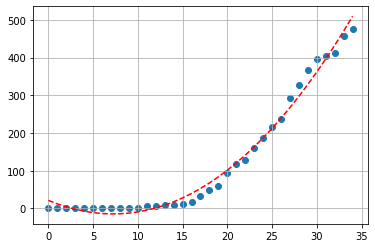

In [75]:
calculate_and_create_chart_for_province(START_DATE, 'Macerata')

## Pesaro e Urbino

Total cases per 1000 inhabitants up to today: 4.3719
Total cases up to today: 1577
New cases registered today: 70
New cases registered today in %: 4.64
Doubling time in the last five days: 24.8
Doubling time yesterday: 25.0
Trend of new cases (in %) in the last 5 days: 15.03


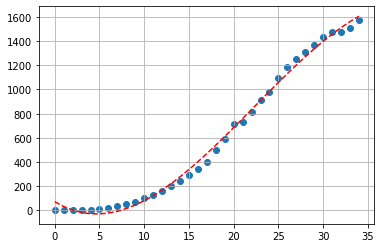

In [76]:
calculate_and_create_chart_for_province(START_DATE, 'Pesaro e Urbino')

# Casi di COVID-19 in Molise - COVID-19 cases in MoliseÂ¶

Total cases up to today: 117
New cases registered today: 7
New cases registered today in %: 6.36
Doubling time in the last five days: 5.7
Doubling time yesterday: 5.4
Trend of new cases (in %) in the last 5 days: 82.81


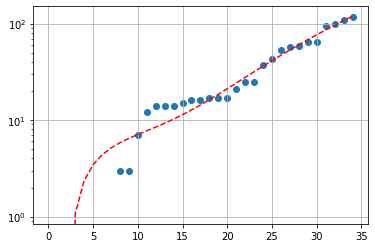

In [77]:
calculate_and_create_chart_for_region(START_DATE, 'Molise')

## Campobasso

Total cases per 1000 inhabitants up to today: 0.4808
Total cases up to today: 108
New cases registered today: 11
New cases registered today in %: 11.34
Doubling time in the last five days: 5.9
Doubling time yesterday: 5.9
Trend of new cases (in %) in the last 5 days: 80.0


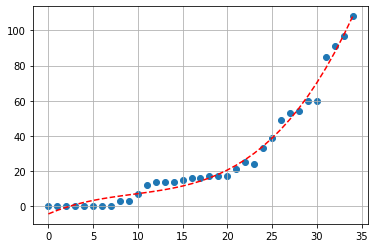

In [78]:
calculate_and_create_chart_for_province(START_DATE, 'Campobasso')

## Isernia

Total cases per 1000 inhabitants up to today: 0.1049
Total cases up to today: 9
New cases registered today: -4
New cases registered today in %: -30.77
Doubling time in the last five days: 4.3
Doubling time yesterday: 2.9
Trend of new cases (in %) in the last 5 days: 125.0


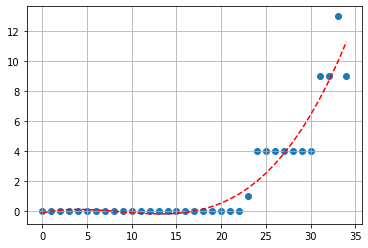

In [79]:
calculate_and_create_chart_for_province(START_DATE, 'Isernia')

# Casi di COVID-19 in Piemonte - COVID-19 cases in Piedmont 

Total cases up to today: 8012
New cases registered today: 520
New cases registered today in %: 6.94
Doubling time in the last five days: 8.6
Doubling time yesterday: 7.5
Trend of new cases (in %) in the last 5 days: 49.59


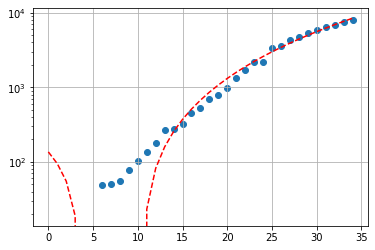

In [80]:
calculate_and_create_chart_for_region(START_DATE, 'Piemonte')

## Alessandria

Total cases per 1000 inhabitants up to today: 2.9415
Total cases up to today: 1255
New cases registered today: 58
New cases registered today in %: 4.85
Doubling time in the last five days: 12.3
Doubling time yesterday: 9.1
Trend of new cases (in %) in the last 5 days: 32.66


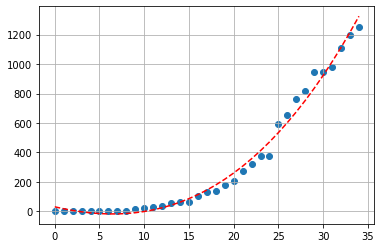

In [81]:
calculate_and_create_chart_for_province(START_DATE, 'Alessandria')

## Asti

Total cases per 1000 inhabitants up to today: 1.5138
Total cases up to today: 328
New cases registered today: 10
New cases registered today in %: 3.14
Doubling time in the last five days: 10.4
Doubling time yesterday: 8.3
Trend of new cases (in %) in the last 5 days: 39.57


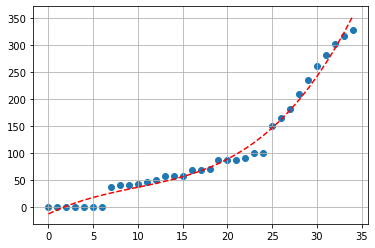

In [82]:
calculate_and_create_chart_for_province(START_DATE, 'Asti')

## Biella

Total cases per 1000 inhabitants up to today: 2.4587
Total cases up to today: 439
New cases registered today: 40
New cases registered today in %: 10.03
Doubling time in the last five days: 7.7
Doubling time yesterday: 7.6
Trend of new cases (in %) in the last 5 days: 56.79


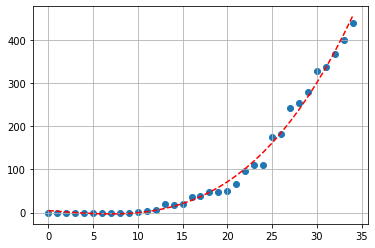

In [83]:
calculate_and_create_chart_for_province(START_DATE, 'Biella')

## Cuneo

Total cases per 1000 inhabitants up to today: 1.0032
Total cases up to today: 591
New cases registered today: 33
New cases registered today in %: 5.91
Doubling time in the last five days: 9.4
Doubling time yesterday: 8.3
Trend of new cases (in %) in the last 5 days: 44.5


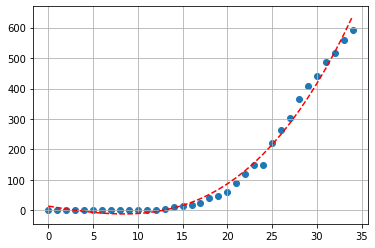

In [84]:
calculate_and_create_chart_for_province(START_DATE, 'Cuneo')

## Novara

Total cases per 1000 inhabitants up to today: 1.875
Total cases up to today: 694
New cases registered today: 37
New cases registered today in %: 5.63
Doubling time in the last five days: 8.9
Doubling time yesterday: 7.7
Trend of new cases (in %) in the last 5 days: 47.35


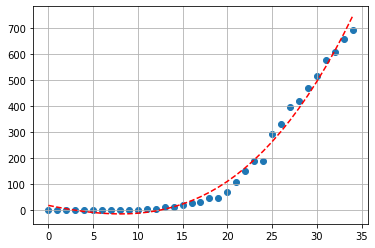

In [85]:
calculate_and_create_chart_for_province(START_DATE, 'Novara')

## Torino

Total cases per 1000 inhabitants up to today: 1.7266
Total cases up to today: 3933
New cases registered today: 275
New cases registered today in %: 7.52
Doubling time in the last five days: 7.6
Doubling time yesterday: 6.8
Trend of new cases (in %) in the last 5 days: 57.57


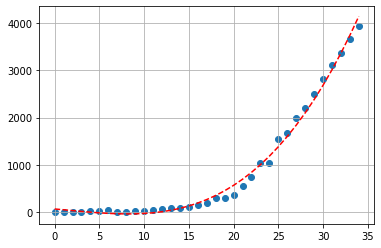

In [86]:
calculate_and_create_chart_for_province(START_DATE, 'Torino')

## 	Verbano-Cusio-Ossola

Total cases per 1000 inhabitants up to today: 2.1671
Total cases up to today: 346
New cases registered today: 38
New cases registered today in %: 12.34
Doubling time in the last five days: 8.4
Doubling time yesterday: 7.2
Trend of new cases (in %) in the last 5 days: 51.09


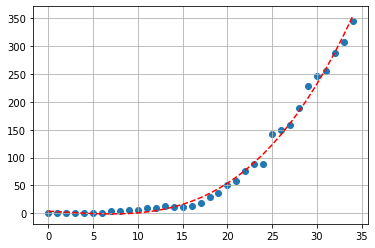

In [87]:
calculate_and_create_chart_for_province(START_DATE, 'Verbano-Cusio-Ossola')

## Vercelli

Total cases per 1000 inhabitants up to today: 2.4501
Total cases up to today: 426
New cases registered today: 29
New cases registered today in %: 7.3
Doubling time in the last five days: 9.0
Doubling time yesterday: 8.4
Trend of new cases (in %) in the last 5 days: 46.9


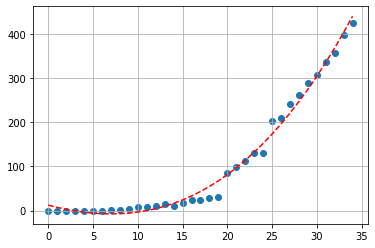

In [88]:
calculate_and_create_chart_for_province(START_DATE, 'Vercelli')

# Casi di COVID-19 in Puglia - COVID-19 cases in Apulia

Total cases up to today: 1483
New cases registered today: 83
New cases registered today in %: 5.93
Doubling time in the last five days: 7.5
Doubling time yesterday: 6.9
Trend of new cases (in %) in the last 5 days: 58.44


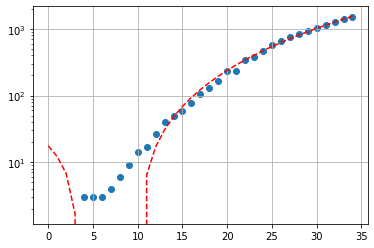

In [89]:
calculate_and_create_chart_for_region(START_DATE, 'Puglia')

## Bari

Total cases per 1000 inhabitants up to today: 0.4111
Total cases up to today: 518
New cases registered today: 49
New cases registered today in %: 10.45
Doubling time in the last five days: 6.5
Doubling time yesterday: 6.2
Trend of new cases (in %) in the last 5 days: 70.39


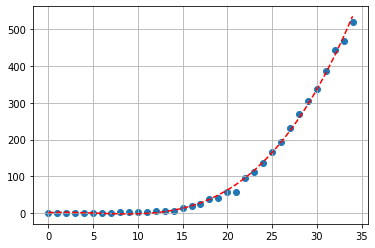

In [90]:
calculate_and_create_chart_for_province(START_DATE, 'Bari')

## 	Barletta-Andria-Trani

Total cases per 1000 inhabitants up to today: 0.2497
Total cases up to today: 98
New cases registered today: 2
New cases registered today in %: 2.08
Doubling time in the last five days: 7.6
Doubling time yesterday: 7.1
Trend of new cases (in %) in the last 5 days: 58.06


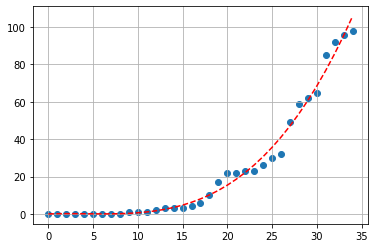

In [91]:
calculate_and_create_chart_for_province(START_DATE, 'Barletta-Andria-Trani')

## Brindisi

Total cases per 1000 inhabitants up to today: 0.3828
Total cases up to today: 152
New cases registered today: 4
New cases registered today in %: 2.7
Doubling time in the last five days: 8.9
Doubling time yesterday: 9.3
Trend of new cases (in %) in the last 5 days: 47.57


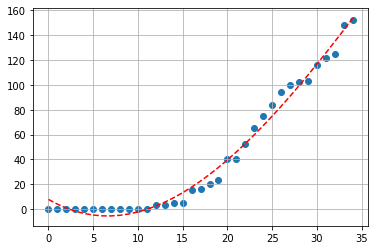

In [92]:
calculate_and_create_chart_for_province(START_DATE, 'Brindisi')

## Foggia

Total cases per 1000 inhabitants up to today: 0.5998
Total cases up to today: 377
New cases registered today: 22
New cases registered today in %: 6.2
Doubling time in the last five days: 8.9
Doubling time yesterday: 7.7
Trend of new cases (in %) in the last 5 days: 47.84


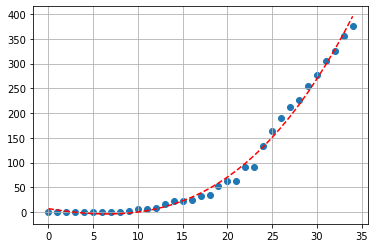

In [93]:
calculate_and_create_chart_for_province(START_DATE, 'Foggia')

## Lecce

Total cases per 1000 inhabitants up to today: 0.298
Total cases up to today: 239
New cases registered today: 0
New cases registered today in %: 0.0
Doubling time in the last five days: 8.8
Doubling time yesterday: 7.3
Trend of new cases (in %) in the last 5 days: 48.45


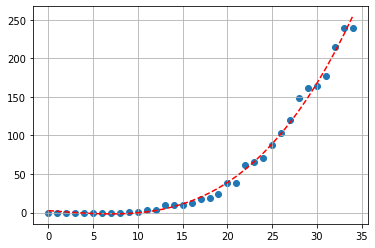

In [94]:
calculate_and_create_chart_for_province(START_DATE, 'Lecce')

## Taranto

Total cases per 1000 inhabitants up to today: 0.1697
Total cases up to today: 99
New cases registered today: 6
New cases registered today in %: 6.45
Doubling time in the last five days: 5.2
Doubling time yesterday: 4.9
Trend of new cases (in %) in the last 5 days: 94.12


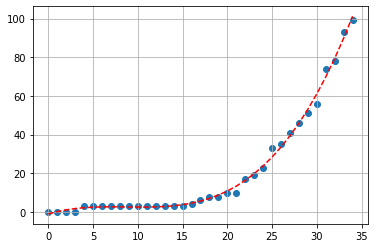

In [95]:
calculate_and_create_chart_for_province(START_DATE, 'Taranto')

# Casi di COVID-19 in Sardegna - COVID-19 cases in Sardinia

Total cases up to today: 638
New cases registered today: 14
New cases registered today in %: 2.24
Doubling time in the last five days: 8.3
Doubling time yesterday: 6.3
Trend of new cases (in %) in the last 5 days: 51.54


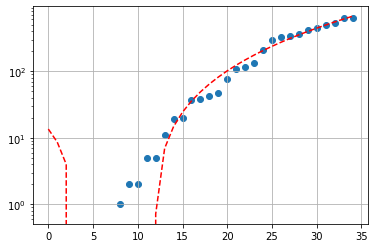

In [96]:
calculate_and_create_chart_for_region(START_DATE, 'Sardegna')

## Cagliari

Total cases per 1000 inhabitants up to today: 0.182
Total cases up to today: 102
New cases registered today: 5
New cases registered today in %: 5.15
Doubling time in the last five days: 7.4
Doubling time yesterday: 7.5
Trend of new cases (in %) in the last 5 days: 59.38


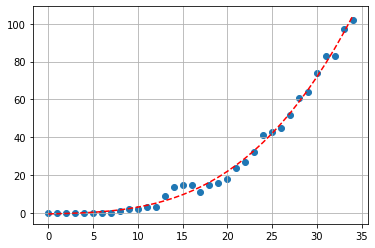

In [97]:
calculate_and_create_chart_for_province(START_DATE, 'Cagliari')

## Nuoro

Total cases per 1000 inhabitants up to today: 0.3652
Total cases up to today: 57
New cases registered today: 1
New cases registered today in %: 1.79
Doubling time in the last five days: 4.4
Doubling time yesterday: 3.7
Trend of new cases (in %) in the last 5 days: 119.23


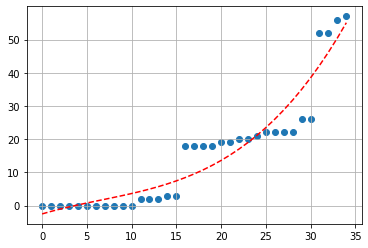

In [98]:
calculate_and_create_chart_for_province(START_DATE, 'Nuoro')

## Oristano

Total cases per 1000 inhabitants up to today: 0.056
Total cases up to today: 9
New cases registered today: 0
New cases registered today in %: 0.0
Doubling time in the last five days: 13.8
Doubling time yesterday: 13.8
Trend of new cases (in %) in the last 5 days: 28.57


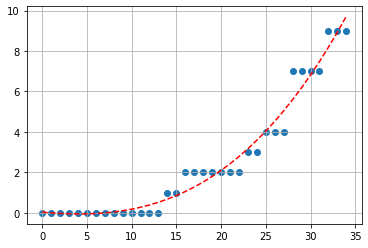

In [99]:
calculate_and_create_chart_for_province(START_DATE, 'Oristano')

## Sassari

Total cases per 1000 inhabitants up to today: 1.2458
Total cases up to today: 415
New cases registered today: 8
New cases registered today in %: 1.97
Doubling time in the last five days: 11.8
Doubling time yesterday: 7.7
Trend of new cases (in %) in the last 5 days: 34.3


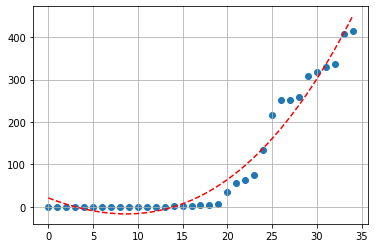

In [100]:
calculate_and_create_chart_for_province(START_DATE, 'Sassari')

# Casi di COVID-19 in Sicilia - COVID-19 cases in Sicily

Total cases up to today: 1460
New cases registered today: 101
New cases registered today in %: 7.43
Doubling time in the last five days: 6.4
Doubling time yesterday: 5.5
Trend of new cases (in %) in the last 5 days: 72.58


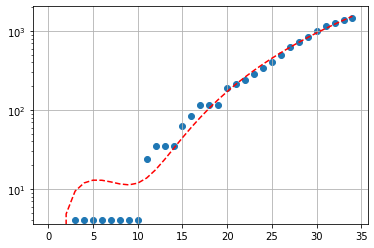

In [101]:
calculate_and_create_chart_for_region(START_DATE, 'Sicilia')

## Agrigento

Total cases per 1000 inhabitants up to today: 0.1765
Total cases up to today: 78
New cases registered today: 20
New cases registered today in %: 34.48
Doubling time in the last five days: 6.8
Doubling time yesterday: 13.7
Trend of new cases (in %) in the last 5 days: 65.96


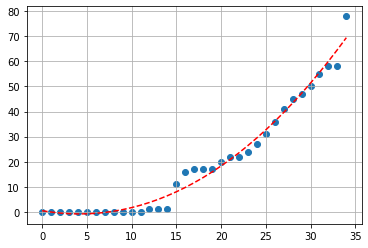

In [102]:
calculate_and_create_chart_for_province(START_DATE, 'Agrigento')

## Caltanissetta

Total cases per 1000 inhabitants up to today: 0.2521
Total cases up to today: 68
New cases registered today: 11
New cases registered today in %: 19.3
Doubling time in the last five days: 6.5
Doubling time yesterday: 5.1
Trend of new cases (in %) in the last 5 days: 70.0


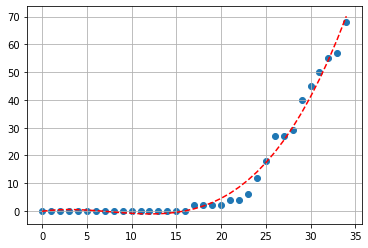

In [103]:
calculate_and_create_chart_for_province(START_DATE, 'Caltanissetta')

## Catania

Total cases per 1000 inhabitants up to today: 0.3656
Total cases up to today: 407
New cases registered today: 20
New cases registered today in %: 5.17
Doubling time in the last five days: 9.8
Doubling time yesterday: 10.0
Trend of new cases (in %) in the last 5 days: 42.31


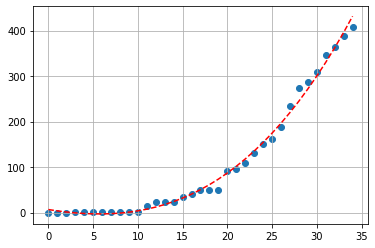

In [104]:
calculate_and_create_chart_for_province(START_DATE, 'Catania')

## Enna

Total cases per 1000 inhabitants up to today: 1.1425
Total cases up to today: 192
New cases registered today: 24
New cases registered today in %: 14.29
Doubling time in the last five days: 3.1
Doubling time yesterday: 2.6
Trend of new cases (in %) in the last 5 days: 204.76


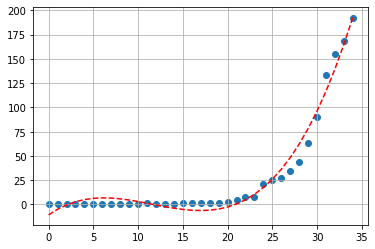

In [105]:
calculate_and_create_chart_for_province(START_DATE, 'Enna')

## Messina

Total cases per 1000 inhabitants up to today: 0.4539
Total cases up to today: 289
New cases registered today: 10
New cases registered today in %: 3.58
Doubling time in the last five days: 4.7
Doubling time yesterday: 4.1
Trend of new cases (in %) in the last 5 days: 107.91


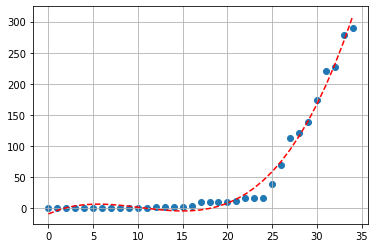

In [106]:
calculate_and_create_chart_for_province(START_DATE, 'Messina')

## Palermo

Total cases per 1000 inhabitants up to today: 0.1861
Total cases up to today: 236
New cases registered today: 4
New cases registered today in %: 1.72
Doubling time in the last five days: 10.6
Doubling time yesterday: 4.6
Trend of new cases (in %) in the last 5 days: 38.82


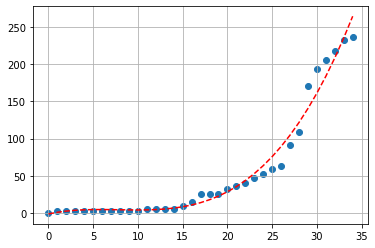

In [107]:
calculate_and_create_chart_for_province(START_DATE, 'Palermo')

## Ragusa

Total cases per 1000 inhabitants up to today: 0.0996
Total cases up to today: 32
New cases registered today: 0
New cases registered today in %: 0.0
Doubling time in the last five days: 2.7
Doubling time yesterday: 2.7
Trend of new cases (in %) in the last 5 days: 255.56


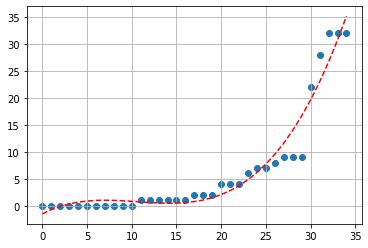

In [108]:
calculate_and_create_chart_for_province(START_DATE, 'Ragusa')

## Siracusa

Total cases per 1000 inhabitants up to today: 0.216
Total cases up to today: 87
New cases registered today: 3
New cases registered today in %: 3.57
Doubling time in the last five days: 6.0
Doubling time yesterday: 6.4
Trend of new cases (in %) in the last 5 days: 77.55


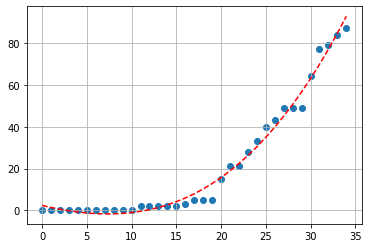

In [109]:
calculate_and_create_chart_for_province(START_DATE, 'Siracusa')

## Trapani

Total cases per 1000 inhabitants up to today: 0.1634
Total cases up to today: 71
New cases registered today: 9
New cases registered today in %: 14.52
Doubling time in the last five days: 6.9
Doubling time yesterday: 8.9
Trend of new cases (in %) in the last 5 days: 65.12


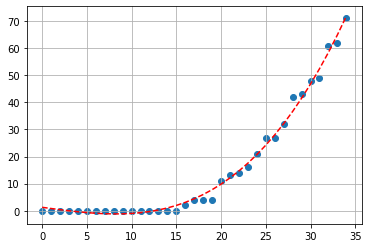

In [110]:
calculate_and_create_chart_for_province(START_DATE, 'Trapani')

# Casi di COVID-19 in Toscana - COVID-19 cases in Tuscany

Total cases up to today: 4122
New cases registered today: 305
New cases registered today in %: 7.99
Doubling time in the last five days: 8.2
Doubling time yesterday: 7.9
Trend of new cases (in %) in the last 5 days: 52.72


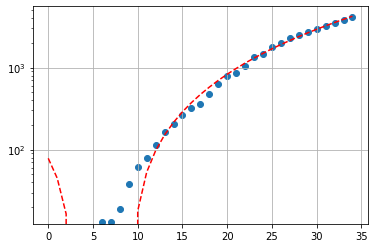

In [111]:
calculate_and_create_chart_for_region(START_DATE, 'Toscana')

## Arezzo

Total cases per 1000 inhabitants up to today: 0.8247
Total cases up to today: 284
New cases registered today: 12
New cases registered today in %: 4.41
Doubling time in the last five days: 11.7
Doubling time yesterday: 11.5
Trend of new cases (in %) in the last 5 days: 34.6


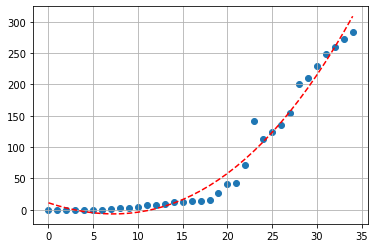

In [112]:
calculate_and_create_chart_for_province(START_DATE, 'Arezzo')

## Firenze

Total cases per 1000 inhabitants up to today: 0.9434
Total cases up to today: 957
New cases registered today: 102
New cases registered today in %: 11.93
Doubling time in the last five days: 8.0
Doubling time yesterday: 7.8
Trend of new cases (in %) in the last 5 days: 53.86


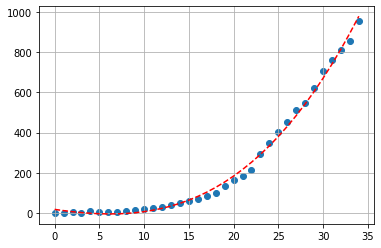

In [113]:
calculate_and_create_chart_for_province(START_DATE, 'Firenze')

## Grosseto

Total cases per 1000 inhabitants up to today: 1.0984
Total cases up to today: 245
New cases registered today: 11
New cases registered today in %: 4.7
Doubling time in the last five days: 6.2
Doubling time yesterday: 5.7
Trend of new cases (in %) in the last 5 days: 75.0


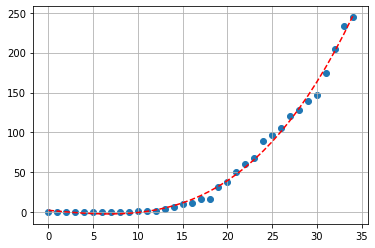

In [114]:
calculate_and_create_chart_for_province(START_DATE, 'Grosseto')

## Livorno

Total cases per 1000 inhabitants up to today: 0.6996
Total cases up to today: 236
New cases registered today: 16
New cases registered today in %: 7.27
Doubling time in the last five days: 9.2
Doubling time yesterday: 7.7
Trend of new cases (in %) in the last 5 days: 45.68


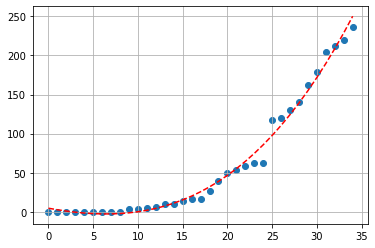

In [115]:
calculate_and_create_chart_for_province(START_DATE, 'Livorno')

## Lucca

Total cases per 1000 inhabitants up to today: 1.7229
Total cases up to today: 672
New cases registered today: 54
New cases registered today in %: 8.74
Doubling time in the last five days: 6.3
Doubling time yesterday: 6.5
Trend of new cases (in %) in the last 5 days: 73.64


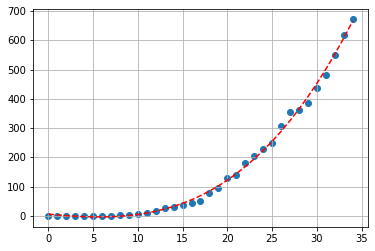

In [116]:
calculate_and_create_chart_for_province(START_DATE, 'Lucca')

## Massa Carrara

Total cases per 1000 inhabitants up to today: 2.5079
Total cases up to today: 493
New cases registered today: 23
New cases registered today in %: 4.89
Doubling time in the last five days: 7.7
Doubling time yesterday: 7.1
Trend of new cases (in %) in the last 5 days: 57.01


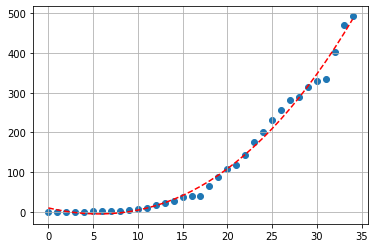

In [117]:
calculate_and_create_chart_for_province(START_DATE, 'Massa Carrara')

## Pisa

Total cases per 1000 inhabitants up to today: 1.0241
Total cases up to today: 432
New cases registered today: 34
New cases registered today in %: 8.54
Doubling time in the last five days: 8.3
Doubling time yesterday: 8.6
Trend of new cases (in %) in the last 5 days: 51.58


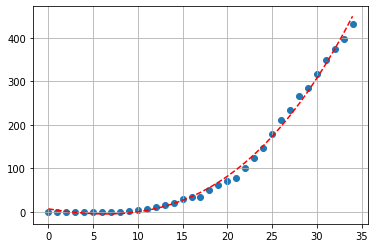

In [118]:
calculate_and_create_chart_for_province(START_DATE, 'Pisa')

## Pistoia

Total cases per 1000 inhabitants up to today: 1.0588
Total cases up to today: 309
New cases registered today: 11
New cases registered today in %: 3.69
Doubling time in the last five days: 14.4
Doubling time yesterday: 13.2
Trend of new cases (in %) in the last 5 days: 27.16


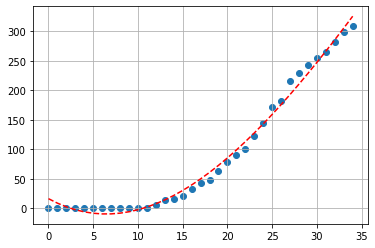

In [119]:
calculate_and_create_chart_for_province(START_DATE, 'Pistoia')

## Prato

Total cases per 1000 inhabitants up to today: 0.868
Total cases up to today: 221
New cases registered today: 4
New cases registered today in %: 1.84
Doubling time in the last five days: 10.5
Doubling time yesterday: 7.5
Trend of new cases (in %) in the last 5 days: 38.99


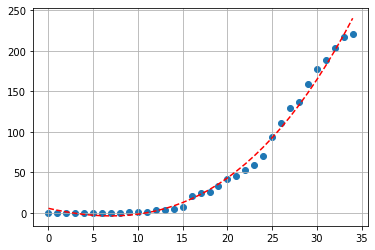

In [120]:
calculate_and_create_chart_for_province(START_DATE, 'Prato')

## Siena

Total cases per 1000 inhabitants up to today: 1.0174
Total cases up to today: 273
New cases registered today: 38
New cases registered today in %: 16.17
Doubling time in the last five days: 7.9
Doubling time yesterday: 9.0
Trend of new cases (in %) in the last 5 days: 55.11


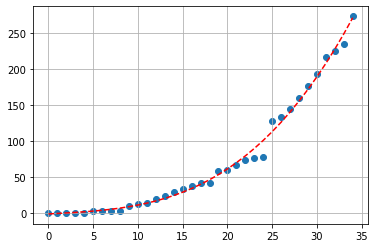

In [121]:
calculate_and_create_chart_for_province(START_DATE, 'Siena')

# Casi di COVID-19 in Provincia Autonoma di Trento - COVID-19 cases in the Autonomous Province of Trento

Total cases per 1000 inhabitants up to today: 2.9595
Total cases up to today: 1594
New cases registered today: 89
New cases registered today in %: 5.91
Doubling time in the last five days: 9.6
Doubling time yesterday: 9.0
Trend of new cases (in %) in the last 5 days: 43.6


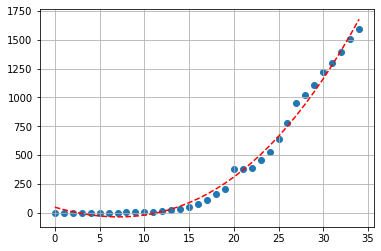

In [122]:
calculate_and_create_chart_for_province(START_DATE, 'Trento')

# Casi di COVID-19 in Umbria - COVID-19 cases in Umbria

Total cases up to today: 993
New cases registered today: 51
New cases registered today in %: 5.41
Doubling time in the last five days: 7.5
Doubling time yesterday: 6.6
Trend of new cases (in %) in the last 5 days: 58.37


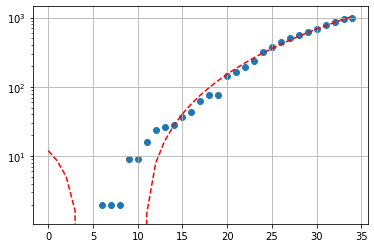

In [123]:
calculate_and_create_chart_for_region(START_DATE, 'Umbria')

## Perugia

Total cases per 1000 inhabitants up to today: 1.173
Total cases up to today: 775
New cases registered today: 46
New cases registered today in %: 6.31
Doubling time in the last five days: 7.0
Doubling time yesterday: 6.4
Trend of new cases (in %) in the last 5 days: 64.19


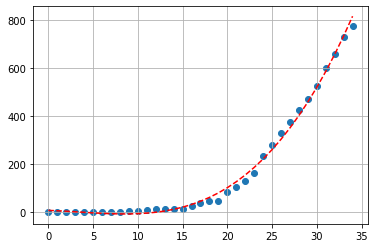

In [124]:
calculate_and_create_chart_for_province(START_DATE, 'Perugia')

## Terni

Total cases per 1000 inhabitants up to today: 0.9552
Total cases up to today: 218
New cases registered today: 5
New cases registered today in %: 2.35
Doubling time in the last five days: 10.2
Doubling time yesterday: 7.5
Trend of new cases (in %) in the last 5 days: 40.65


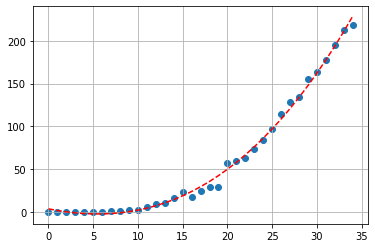

In [125]:
calculate_and_create_chart_for_province(START_DATE, 'Terni')

# Casi di COVID-19 in Valle d'Aosta - COVID-19 cases in Aosta Valley

Total cases per 1000 inhabitants up to today: 4.6027
Total cases up to today: 584
New cases registered today: 73
New cases registered today in %: 14.29
Doubling time in the last five days: 9.2
Doubling time yesterday: 13.2
Trend of new cases (in %) in the last 5 days: 46.0


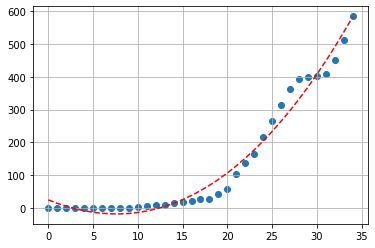

In [126]:
calculate_and_create_chart_for_province(START_DATE, "Aosta")

# Casi di COVID-19 in Veneto - COVID-19 cases in Veneto

Total cases up to today: 8094
New cases registered today: 428
New cases registered today in %: 5.58
Doubling time in the last five days: 10.0
Doubling time yesterday: 9.4
Trend of new cases (in %) in the last 5 days: 41.53


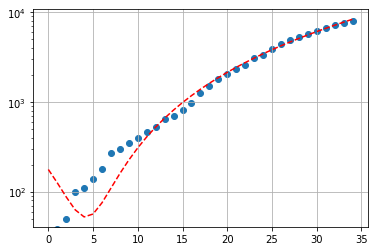

In [127]:
calculate_and_create_chart_for_region(START_DATE, 'Veneto')

## Belluno

Total cases per 1000 inhabitants up to today: 1.9244
Total cases up to today: 396
New cases registered today: 29
New cases registered today in %: 7.9
Doubling time in the last five days: 9.3
Doubling time yesterday: 9.4
Trend of new cases (in %) in the last 5 days: 45.05


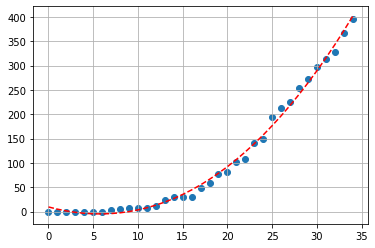

In [128]:
calculate_and_create_chart_for_province(START_DATE, 'Belluno')

## Padova

Total cases per 1000 inhabitants up to today: 2.2686
Total cases up to today: 2124
New cases registered today: 115
New cases registered today in %: 5.72
Doubling time in the last five days: 9.3
Doubling time yesterday: 9.1
Trend of new cases (in %) in the last 5 days: 45.08


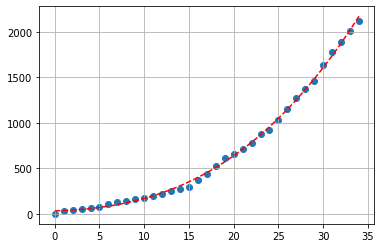

In [129]:
calculate_and_create_chart_for_province(START_DATE, 'Padova')

## Rovigo

Total cases per 1000 inhabitants up to today: 0.5239
Total cases up to today: 125
New cases registered today: 3
New cases registered today in %: 2.46
Doubling time in the last five days: 8.2
Doubling time yesterday: 8.2
Trend of new cases (in %) in the last 5 days: 52.44


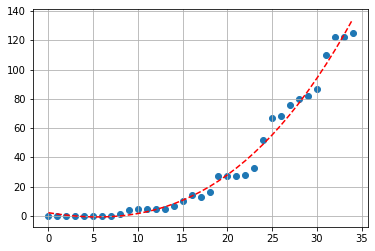

In [130]:
calculate_and_create_chart_for_province(START_DATE, 'Rovigo')

## Treviso

Total cases per 1000 inhabitants up to today: 1.5824
Total cases up to today: 1402
New cases registered today: 43
New cases registered today in %: 3.16
Doubling time in the last five days: 13.8
Doubling time yesterday: 11.3
Trend of new cases (in %) in the last 5 days: 28.51


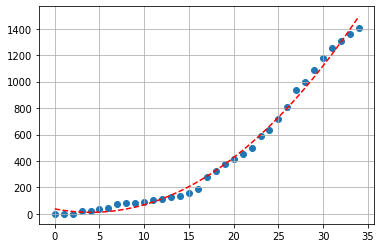

In [131]:
calculate_and_create_chart_for_province(START_DATE, 'Treviso')

## Venezia

Total cases per 1000 inhabitants up to today: 1.249
Total cases up to today: 1067
New cases registered today: 48
New cases registered today in %: 4.71
Doubling time in the last five days: 14.3
Doubling time yesterday: 14.2
Trend of new cases (in %) in the last 5 days: 27.48


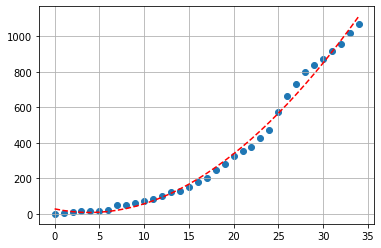

In [132]:
calculate_and_create_chart_for_province(START_DATE, 'Venezia')

## Verona

Total cases per 1000 inhabitants up to today: 2.0357
Total cases up to today: 1876
New cases registered today: 122
New cases registered today in %: 6.96
Doubling time in the last five days: 8.2
Doubling time yesterday: 7.4
Trend of new cases (in %) in the last 5 days: 52.77


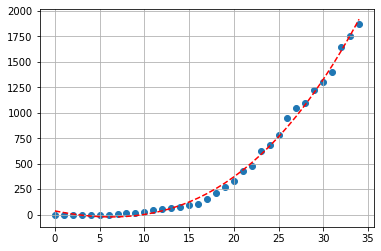

In [133]:
calculate_and_create_chart_for_province(START_DATE, 'Verona')

## Vicenza

Total cases per 1000 inhabitants up to today: 1.2762
Total cases up to today: 1104
New cases registered today: 68
New cases registered today in %: 6.56
Doubling time in the last five days: 8.8
Doubling time yesterday: 8.6
Trend of new cases (in %) in the last 5 days: 48.39


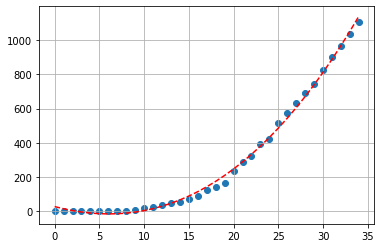

In [134]:
calculate_and_create_chart_for_province(START_DATE, 'Vicenza')